In [1]:
# ========== CONFIG & IMPORTS ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn

# File paths
PRICES_CSV = "../spx100_prices.csv"              # Daily adjusted prices (with 'Date' column)
SECTOR_CSV = "ticker_industries.csv"          # Ticker -> Sector mapping

# Parameters
LOOKBACK_MONTHS = [3, 2, 1]                   # Try different momentum windows
MAX_SECTOR_WEIGHT = 0.25                      # Sector max cap
MAX_STOCK_WEIGHT = 0.05                       # Individual stock cap
ALPHA = 0.95
ANNUAL_TRADING_DAYS = 252
RISK_FREE_RATE = 0.0


In [2]:
# Load prices
prices = pd.read_csv(PRICES_CSV, parse_dates=["Date"], index_col="Date").sort_index()
print("✅ Prices Data (first 5 rows):")
display(prices.head())

# Load sector classification
sector_df = pd.read_csv(SECTOR_CSV)
print("\n✅ Sector Mapping (first 5 rows):")
display(sector_df.head())

# Print a sample of tickers with sectors
print("\n✅ Sample Ticker-to-Sector Mapping:")
print(sector_df.groupby("Sector")["Ticker"].apply(list).head(10))


✅ Prices Data (first 5 rows):


,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.43,NaN,18.53,31.65,37.090000,16.45,9.70,39.91,32.62,6.70,...,17.41,24.92,23.46,35.22,14.39,19.72,14.16,18.23,13.02,38.57
2010-01-05,6.44,NaN,18.38,31.85,37.700000,16.15,9.71,39.57,33.16,6.73,...,17.31,24.88,23.78,35.28,14.76,19.49,14.19,18.73,12.89,38.72
2010-01-06,6.34,NaN,18.48,32.18,37.619999,16.04,9.57,39.27,33.34,6.61,...,17.19,25.13,23.82,35.02,14.91,19.23,13.78,18.75,12.86,39.05
2010-01-07,6.33,NaN,18.63,32.15,36.889999,15.73,9.47,38.91,33.25,6.50,...,17.24,26.09,23.61,34.75,15.20,19.41,13.70,19.43,12.87,38.93
2010-01-08,6.37,NaN,18.73,32.03,36.689999,16.15,9.43,39.26,33.31,6.68,...,17.63,25.85,24.41,36.42,15.23,19.46,13.71,19.25,12.80,38.78



✅ Sector Mapping (first 5 rows):


,Ticker,Company,Sector,Industry
0,AAPL,Apple Inc.,Technology,Consumer Electronics
1,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
2,ABT,Abbott Laboratories,Healthcare,Medical - Devices
3,ACN,Accenture plc,Technology,Information Technology Services
4,ADBE,Adobe Inc.,Technology,Software - Infrastructure



✅ Sample Ticker-to-Sector Mapping:
Sector
Basic Materials                                                       [LIN]
Communication Services    [CHTR, CMCSA, DIS, GOOG, GOOGL, META, NFLX, T,...
Consumer Cyclical           [AMZN, BKNG, GM, HD, LOW, MCD, NKE, SBUX, TSLA]
Consumer Defensive          [CL, COST, KO, MDLZ, MO, PEP, PG, PM, TGT, WMT]
Energy                                                      [COP, CVX, XOM]
Financial Services        [AIG, AXP, BAC, BK, BLK, C, COF, GS, JPM, MA, ...
Healthcare                [ABBV, ABT, AMGN, BMY, CVS, DHR, GILD, ISRG, J...
Industrials               [BA, CAT, DE, EMR, FDX, GD, GE, HON, LMT, MMM,...
Real Estate                                                      [AMT, SPG]
Technology                [AAPL, ACN, ADBE, AMD, AVGO, CRM, CSCO, IBM, I...
Name: Ticker, dtype: object


In [3]:
# Define monthly and quarterly rebalance dates (last trading day of month/quarter)
monthly_rebalance_dates = prices.resample('ME').last().index
quarterly_rebalance_dates = prices.resample('QE').last().index

print("📅 Monthly Rebalance Dates (first 5):")
display(monthly_rebalance_dates[:5])

print("\n📅 Quarterly Rebalance Dates (first 5):")
display(quarterly_rebalance_dates[:5])




📅 Monthly Rebalance Dates (first 5):


DatetimeIndex(['2010-01-31', '2010-02-28', '2010-03-31', '2010-04-30',
               '2010-05-31'],
              dtype='datetime64[ns]', name='Date', freq='ME')


📅 Quarterly Rebalance Dates (first 5):


DatetimeIndex(['2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31'],
              dtype='datetime64[ns]', name='Date', freq='QE-DEC')

/tmp/ipykernel_63053/1881139963.py:41: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  period_returns = period_prices.pct_change().dropna()


📉 Average turnover per rebalance for Monthly MV Momentum: 13.36%


/tmp/ipykernel_63053/1881139963.py:41: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  period_returns = period_prices.pct_change().dropna()
/tmp/ipykernel_63053/1881139963.py:66: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  benchmark_returns = prices.pct_change().dropna().mean(axis=1)


📉 Average turnover per rebalance for Quarterly MV Momentum: 21.65%


/home/zech/Desktop/Work Space - Linux/eToro/quantprogram2025/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


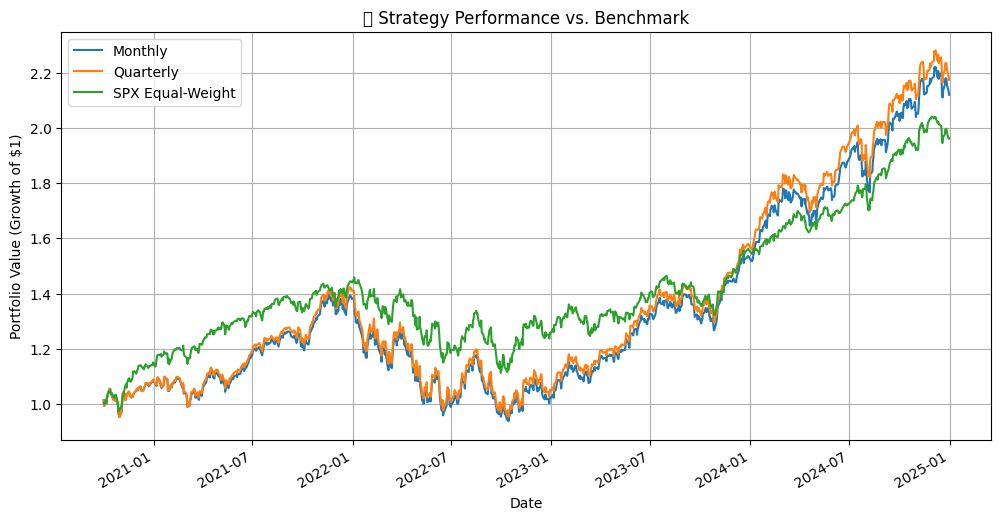

In [5]:
def run_backtest(prices, rebalance_dates, momentum_days, strategy_label):
    portfolio_returns = []
    turnover_list = []

    prev_weights = pd.Series(0, index=prices.columns)

    for i in range(1, len(rebalance_dates)):
        start_date = rebalance_dates[i - 1]
        end_date = rebalance_dates[i]

        price_slice = prices.loc[:start_date].dropna(axis=1, how='any')
        if len(price_slice) < momentum_days:
            continue

        # Compute momentum
        momentum = price_slice.iloc[-1] / price_slice.iloc[-momentum_days] - 1
        momentum = momentum.dropna()

        # Mean & cov for MV optimization
        returns_window = price_slice[momentum.index].pct_change().dropna()
        mu = returns_window.mean()
        Sigma = returns_window.cov()

        # Optimization
        w = cp.Variable(len(mu))
        objective = cp.Maximize(mu.values @ w - 0.5 * cp.quad_form(w, Sigma.values))
        constraints = [cp.sum(w) == 1, w >= 0, w <= MAX_STOCK_WEIGHT]
        prob = cp.Problem(objective, constraints)
        prob.solve()

        weights = pd.Series(w.value, index=mu.index)
        weights = weights / weights.sum()

        # Calculate turnover and cost
        turnover = np.abs(weights - prev_weights[weights.index]).sum()
        cost = turnover * 0.001  # 10 bps (0.1%) total round-trip
        turnover_list.append(turnover)

        # Calculate period returns
        period_prices = prices.loc[start_date:end_date, weights.index]
        period_returns = period_prices.pct_change().dropna()
        weighted_returns = (period_returns * weights).sum(axis=1)

        # Apply cost on first day
        if not weighted_returns.empty:
            weighted_returns.iloc[0] -= cost

        portfolio_returns.append(weighted_returns)
        prev_weights = weights

    returns = pd.concat(portfolio_returns)
    avg_turnover = np.mean(turnover_list)
    print(f"📉 Average turnover per rebalance for {strategy_label}: {avg_turnover:.2%}")

    return returns



# Run both monthly and quarterly momentum strategies
momentum_days = 63  # ~3 months
monthly_returns = run_backtest(prices, monthly_rebalance_dates, momentum_days, "Monthly MV Momentum")
quarterly_returns = run_backtest(prices, quarterly_rebalance_dates, momentum_days, "Quarterly MV Momentum")

# Benchmark: equal-weight SPX portfolio (no rebalance)
equal_weight = 1 / prices.shape[1]
benchmark_returns = prices.pct_change().dropna().mean(axis=1)

# Combine
strategy_df = pd.DataFrame({
    "Monthly": monthly_returns,
    "Quarterly": quarterly_returns,
    "SPX Equal-Weight": benchmark_returns
}).dropna()

# Combine
strategy_df = pd.DataFrame({
    "Monthly": monthly_returns,
    "Quarterly": quarterly_returns,
    "SPX Equal-Weight": benchmark_returns
}).dropna()

# Save daily and cumulative returns
strategy_df.to_csv("daily_strategy_returns.csv")
cumulative = (1 + strategy_df).cumprod()
cumulative.to_csv("cumulative_strategy_returns.csv")


# Plot
cumulative.plot(figsize=(12, 6), title="📈 Strategy Performance vs. Benchmark")
plt.ylabel("Portfolio Value (Growth of $1)")
plt.grid(True)
plt.show()




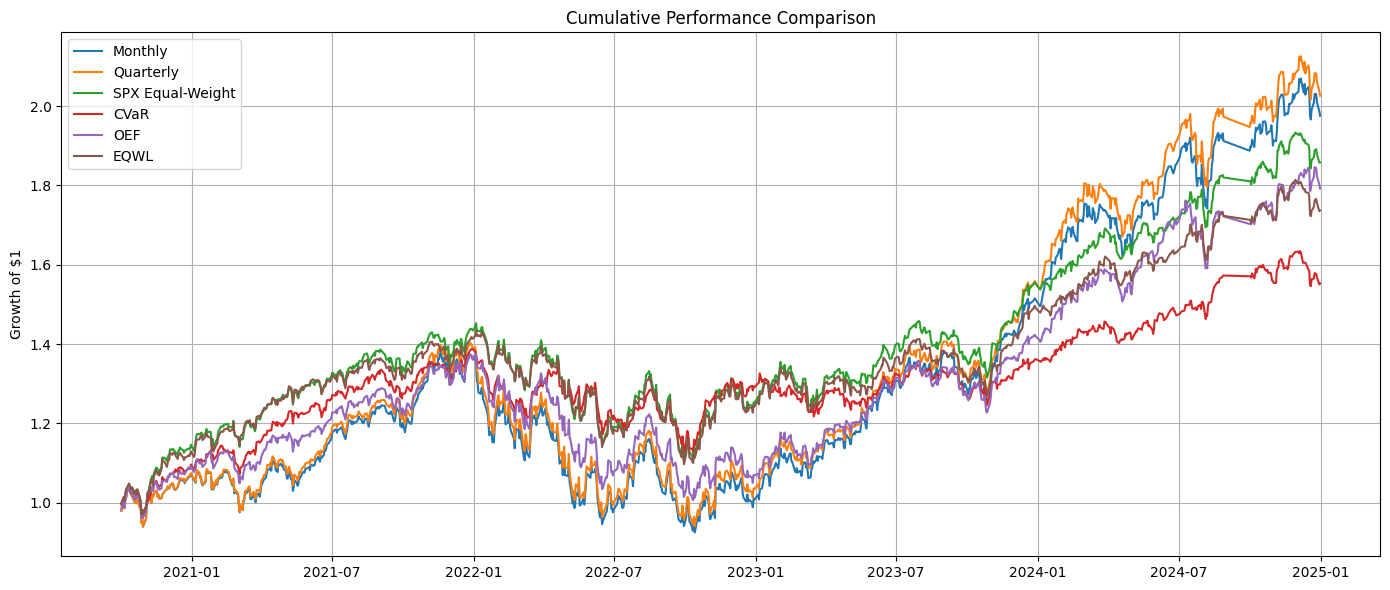

📊 Summary Table


/tmp/ipykernel_63053/3792402711.py:49: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = combined.resample("Y").apply(lambda x: (1 + x).prod() - 1)


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Monthly,97.58%,18.84%,20.94%,89.99%,-32.92%
Quarterly,102.64%,19.48%,21.03%,92.63%,-33.01%
SPX Equal-Weight,85.79%,16.38%,15.73%,104.16%,-23.72%
CVaR,55.32%,11.56%,12.61%,91.65%,-18.86%
OEF,79.24%,15.75%,17.24%,91.38%,-26.86%
EQWL,73.73%,14.65%,15.11%,96.91%,-23.56%



📅 Yearly Returns


,Monthly,Quarterly,SPX Equal-Weight,CVaR,OEF,EQWL
Date,,,,,,
2020,7.23%,7.45%,14.63%,9.63%,9.13%,12.94%
2021,26.94%,29.27%,25.10%,26.50%,24.68%,25.17%
2022,-25.99%,-25.58%,-12.77%,-6.92%,-21.45%,-12.11%
2023,50.10%,50.44%,24.07%,5.54%,32.79%,20.02%
2024,30.65%,30.30%,19.71%,14.01%,26.30%,16.51%


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ANNUAL_TRADING_DAYS = 252

# 📥 Load your strategy results
strategy_df = pd.read_csv("daily_strategy_returns.csv", index_col="Date", parse_dates=True)

# 📥 Load external benchmarks
cvar = pd.read_csv("../cvar_index_quarterly_txn_cost.csv", index_col="Date", parse_dates=True).squeeze()
cvar_returns = cvar.pct_change().dropna()

bench = pd.read_csv("../benchmarks.csv", index_col="Date", parse_dates=True)
bench = bench.loc[strategy_df.index.min():strategy_df.index.max()]
bench_returns = bench.pct_change().dropna()

# 📊 Combine all
combined = pd.concat([
    strategy_df,
    cvar_returns.rename("CVaR"),
    bench_returns
], axis=1).dropna()

# 📈 Cumulative performance
cumulative = (1 + combined).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(cumulative)
plt.title("Cumulative Performance Comparison")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend(cumulative.columns)
plt.tight_layout()
plt.show()

# 🧮 Summary metrics
def max_drawdown(series):
    return ((series / series.cummax()) - 1).min()

summary = pd.DataFrame(index=combined.columns)
summary["Total Return"] = (1 + combined).prod() - 1
summary["Annualized Return"] = combined.mean() * ANNUAL_TRADING_DAYS
summary["Annualized Volatility"] = combined.std() * np.sqrt(ANNUAL_TRADING_DAYS)
summary["Sharpe Ratio"] = summary["Annualized Return"] / summary["Annualized Volatility"]
summary["Max Drawdown"] = combined.apply(lambda x: ((1 + x).cumprod() / (1 + x).cumprod().cummax() - 1).min())

# 📆 Yearly return table
yearly_returns = combined.resample("Y").apply(lambda x: (1 + x).prod() - 1)
yearly_returns.index = yearly_returns.index.year

print("📊 Summary Table")
display(summary.style.format("{:.2%}"))

print("\n📅 Yearly Returns")
display(yearly_returns.style.format("{:.2%}"))

